# **`word2vec` Training Workflow**
In this workflow, we first train `word2vec` models across years using a range of hyperparameters (e.g., vector dimensions and training epochs). The purpose is twofold: (1) to determine whether earlier models are reasonably stable, and (2) choose a set of hyperparameters that yield good results across all years. Models are evaluated using "intrinsic" tests of similarity and analogy performance, which we visualize using plots and analyze using linear regression.

Once we've chosen a set of hyperparameters, we use it to train models for every year from 1900 through 2019.

## **Setup**
### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from ngramkit.ngram_train.word2vec import train_models, evaluate_models, plot_evaluation_results
from ngramkit.utilities.notebook_logging import setup_notebook_logging
from ngramkit.ngram_train.word2vec import run_regression_analysis, plot_regression_results

## **Test Model Hyperparameters**
### Train `word2vec` Models
Here we test models from 1900 tp 2015 in 5-year increments, cycling through a range of reasonable hyperparameters. We stick to the `skip-gram` approach rather than trying `CBOW`, as `skip-gram` is generally the most efficient for Google Ngrams. Vector dimensions from 100 to 300 are tested; more is not advisable, since our small vocabulary size can't support extraction of more than 300 meaningful features. Epochs from 5 to 30 are tested; more than 30 risks overfitting. Because we've ensured that every vocabulary word appears frequently in every corpus from 1900–2015, we simply set `min_count` to 1. Weighting is set to `none`, since `word2vec` already downweights extremely frequent words. Finally, we set a context window of 4. which extracts as much context as possible from 5-grams.

In [4]:
src_path = '/scratch/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files'

setup_notebook_logging(
    workflow_name="training_workflow",
    console=False
)

train_models(
    corpus_path=src_path,
    dir_suffix='test',
    years=(1900, 2015),
    year_step=5,
    weight_by=('none',),
    vector_size=(100, 200, 300),
    window=(4,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(5, 10, 15, 20, 25, 30),
    max_parallel_models=33,
    workers_per_model=3,
    mode="resume",
    unk_mode="strip",
    use_corpus_file=True
)


Scanning for existing models...


Scanning existing models: 100%|██████████| 432/432 [00:04<00:00, 96.57 files/s] 

  Valid models found:    432
  Invalid/partial:       0

WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-10 19:18:24

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             .../edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/5grams_pivoted.db
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Log directory:        .../edk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_test/training
Parallel models:      33

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2015 (step=5, 24 years)
Weighting:            ('none',)
Vector size:          (100, 200, 300)
Context window:       (4,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training e

Execution
────────────────────────────────────────────────────────────────────────────────────────────────────
Total models in grid: 432
Existing valid:       432
Models to train:      0
Parameter combos:     18
Years:                24



Training Models: 0 models [00:00, ? models/s]


Training Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models trained:       0
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



### Evaluate `word2vec` Models

Here we evaluate the models we've trained uning "intrinsic" tests. Specifically, we test how well each model's embeddings can predict human-rated similarity judgments and correctly answer SAT-style analogy questions. Test results are saved to a CSV file.

Similarity performance is the metric of choice for models intended to track semantic relatedness over time. However, we run both tests here to demonstrate the evaluation code and show that different hyperparameters lend themselves to different performance metrics.

In [5]:
mod_path = '/scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files'

setup_notebook_logging(
    workflow_name="evaluation_workflow",
    data_path=mod_path,
    console=False
)

evaluate_models(
    model_dir=mod_path,
    dir_suffix='test',
    eval_dir=mod_path,
    save_mode='overwrite',
    run_similarity=True,
    run_analogy=True,
    workers=100
)


WORD2VEC MODEL EVALUATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-10 19:19:38

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Evaluation file:      ...LP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv
Log directory:        ...dk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_test/evaluation
Save mode:            overwrite

Evaluation Datasets
────────────────────────────────────────────────────────────────────────────────────────────────────
Similarity dataset:   ...miniforge/lib/python3.11/site-packages/gensim/test/test_data/wordsim353.tsv
Analogy dataset:      ...orge/lib/python3.11/site-packages/gensim/test/test_data/questions-words.txt

Found 432 models to evaluate



Evaluating models: 100%|██████████| 432/432 [32:46<00:00,  4.55s/ models]  


Evaluation Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models evaluated:     432
Results saved to:     ...LP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



### Visualize Model Performance
The code below plots the results of the similarity and analogy tests for easy inspection.
#### Similarity Results
Visual inspection of the similarity plots reveals that all models display decent performance, with the earliest models scores in the .50–.55 range and the most recent models in the .58–.62 range. Overall, then, the models are performing well for ngram-based semantic relatedness. Vector dimensions and training epochs don't seem to matter much overall.

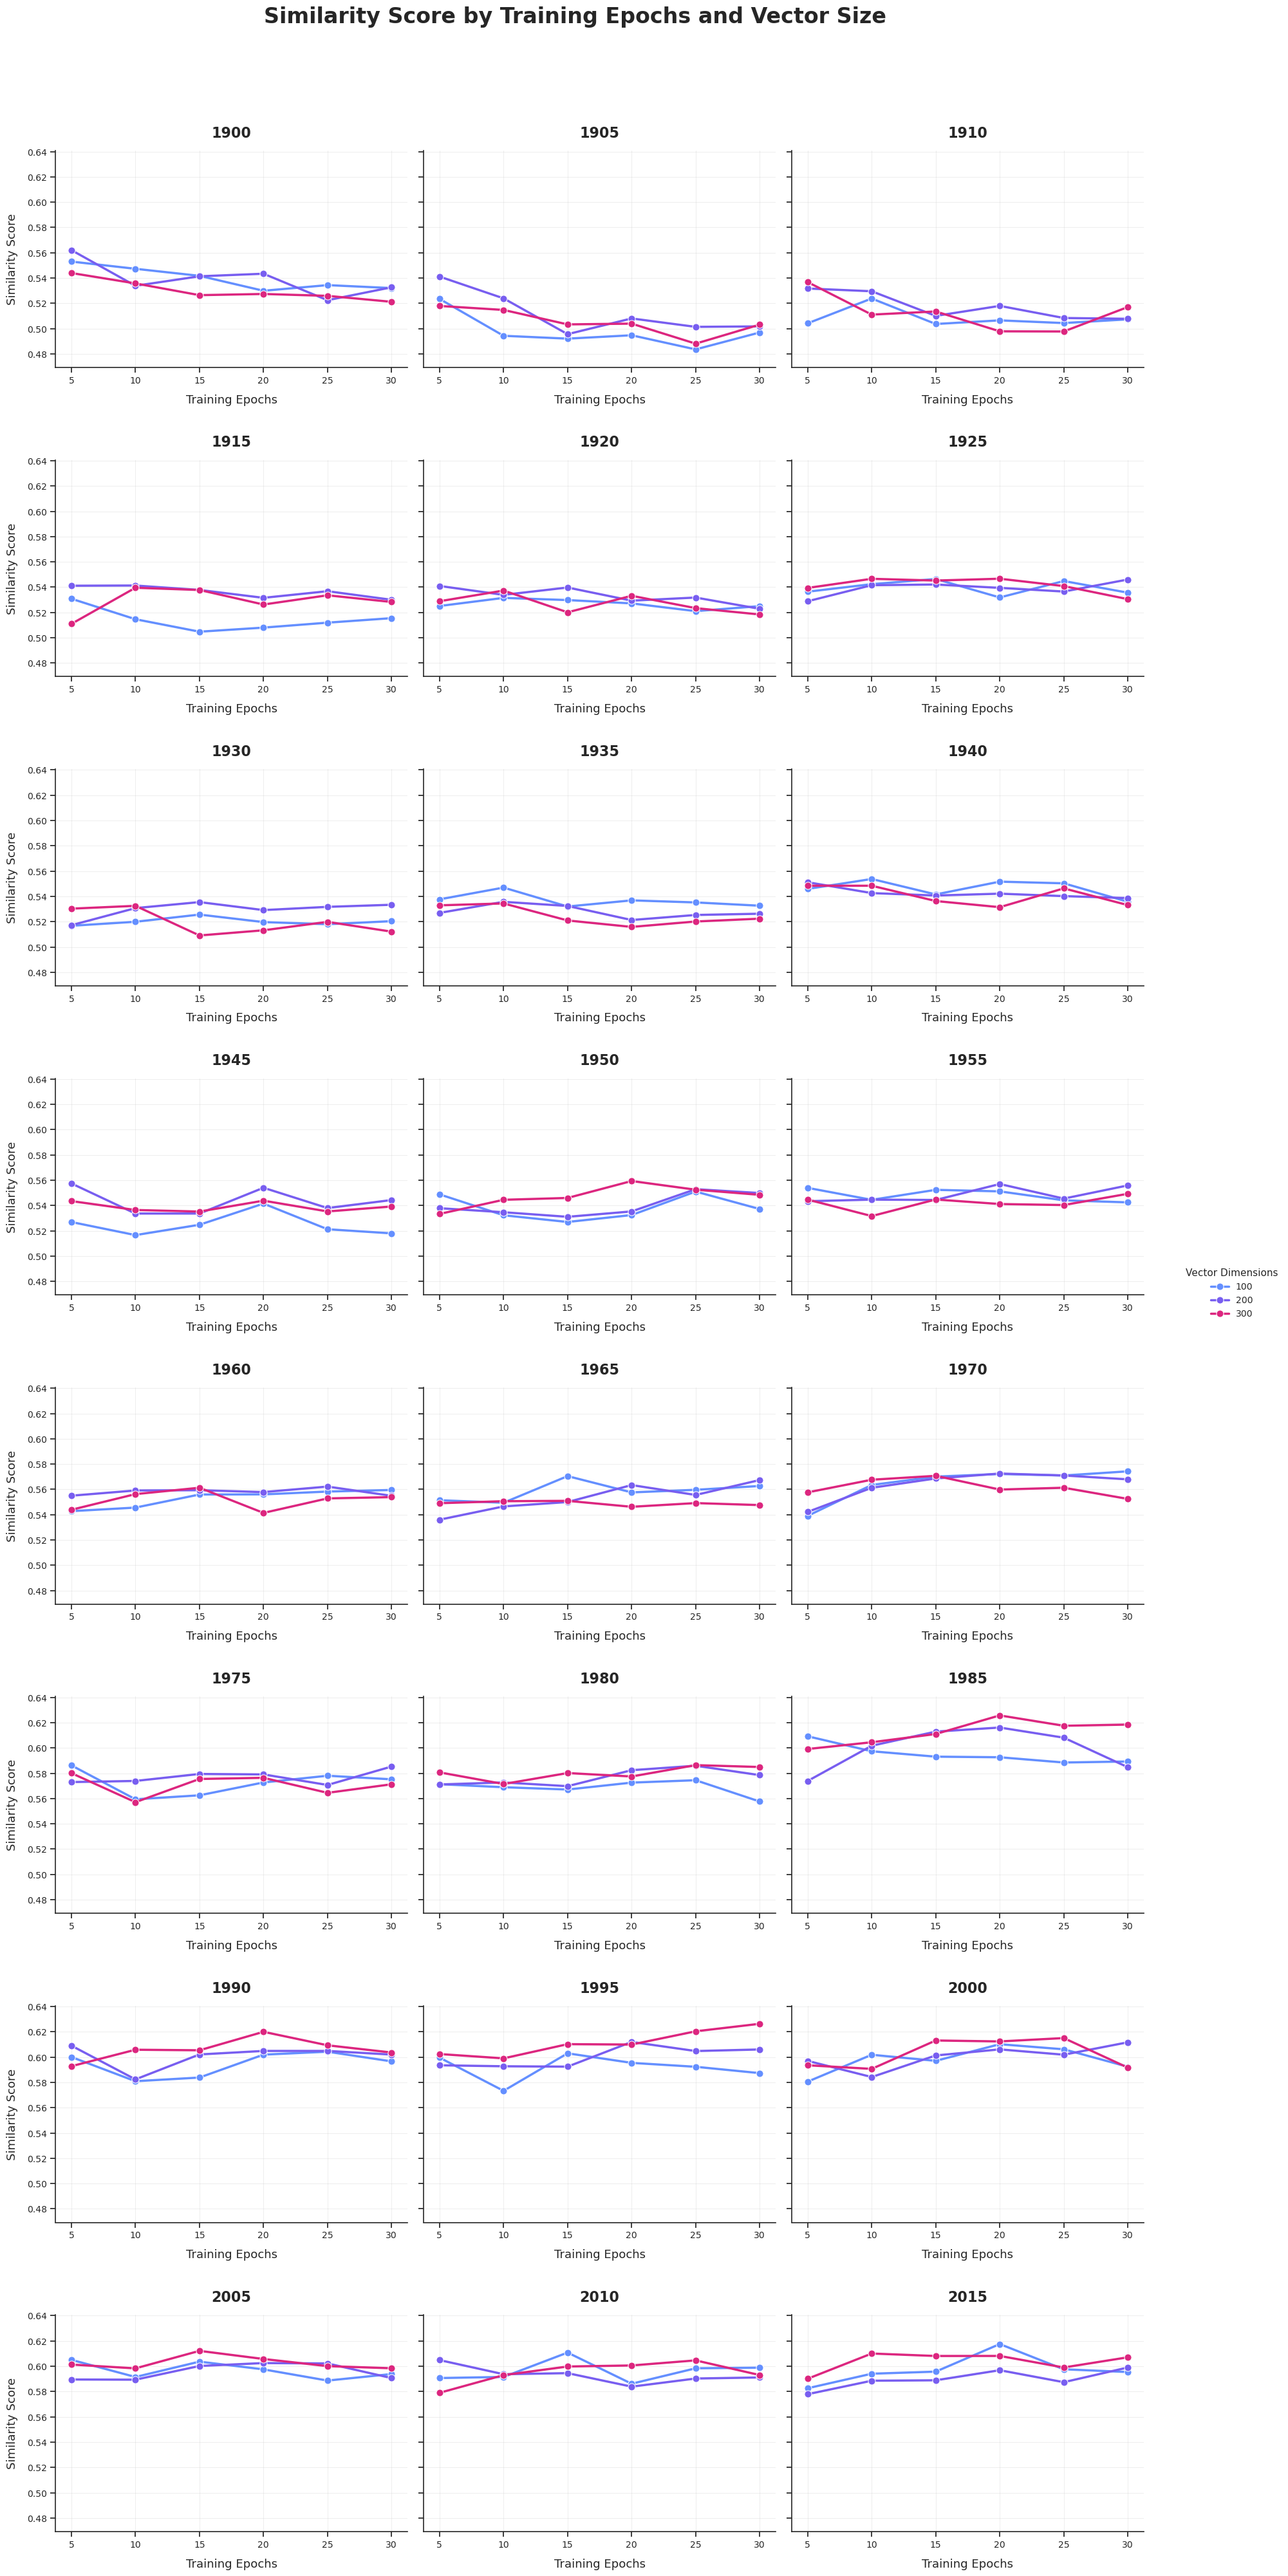

In [4]:
eval_file = '/scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

plot_evaluation_results(
    csv_file=eval_file,
    verbose=False,
    metric='similarity_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Similarity Score by Training Epochs and Vector Size'
)

#### Analogy Results
Like the similarity results, model performance improves with the corpus recency. Unlike the similarity results, analogy performance clearly improves with the number training epochs. The number of vector dimensions doesn't seem to matter much.

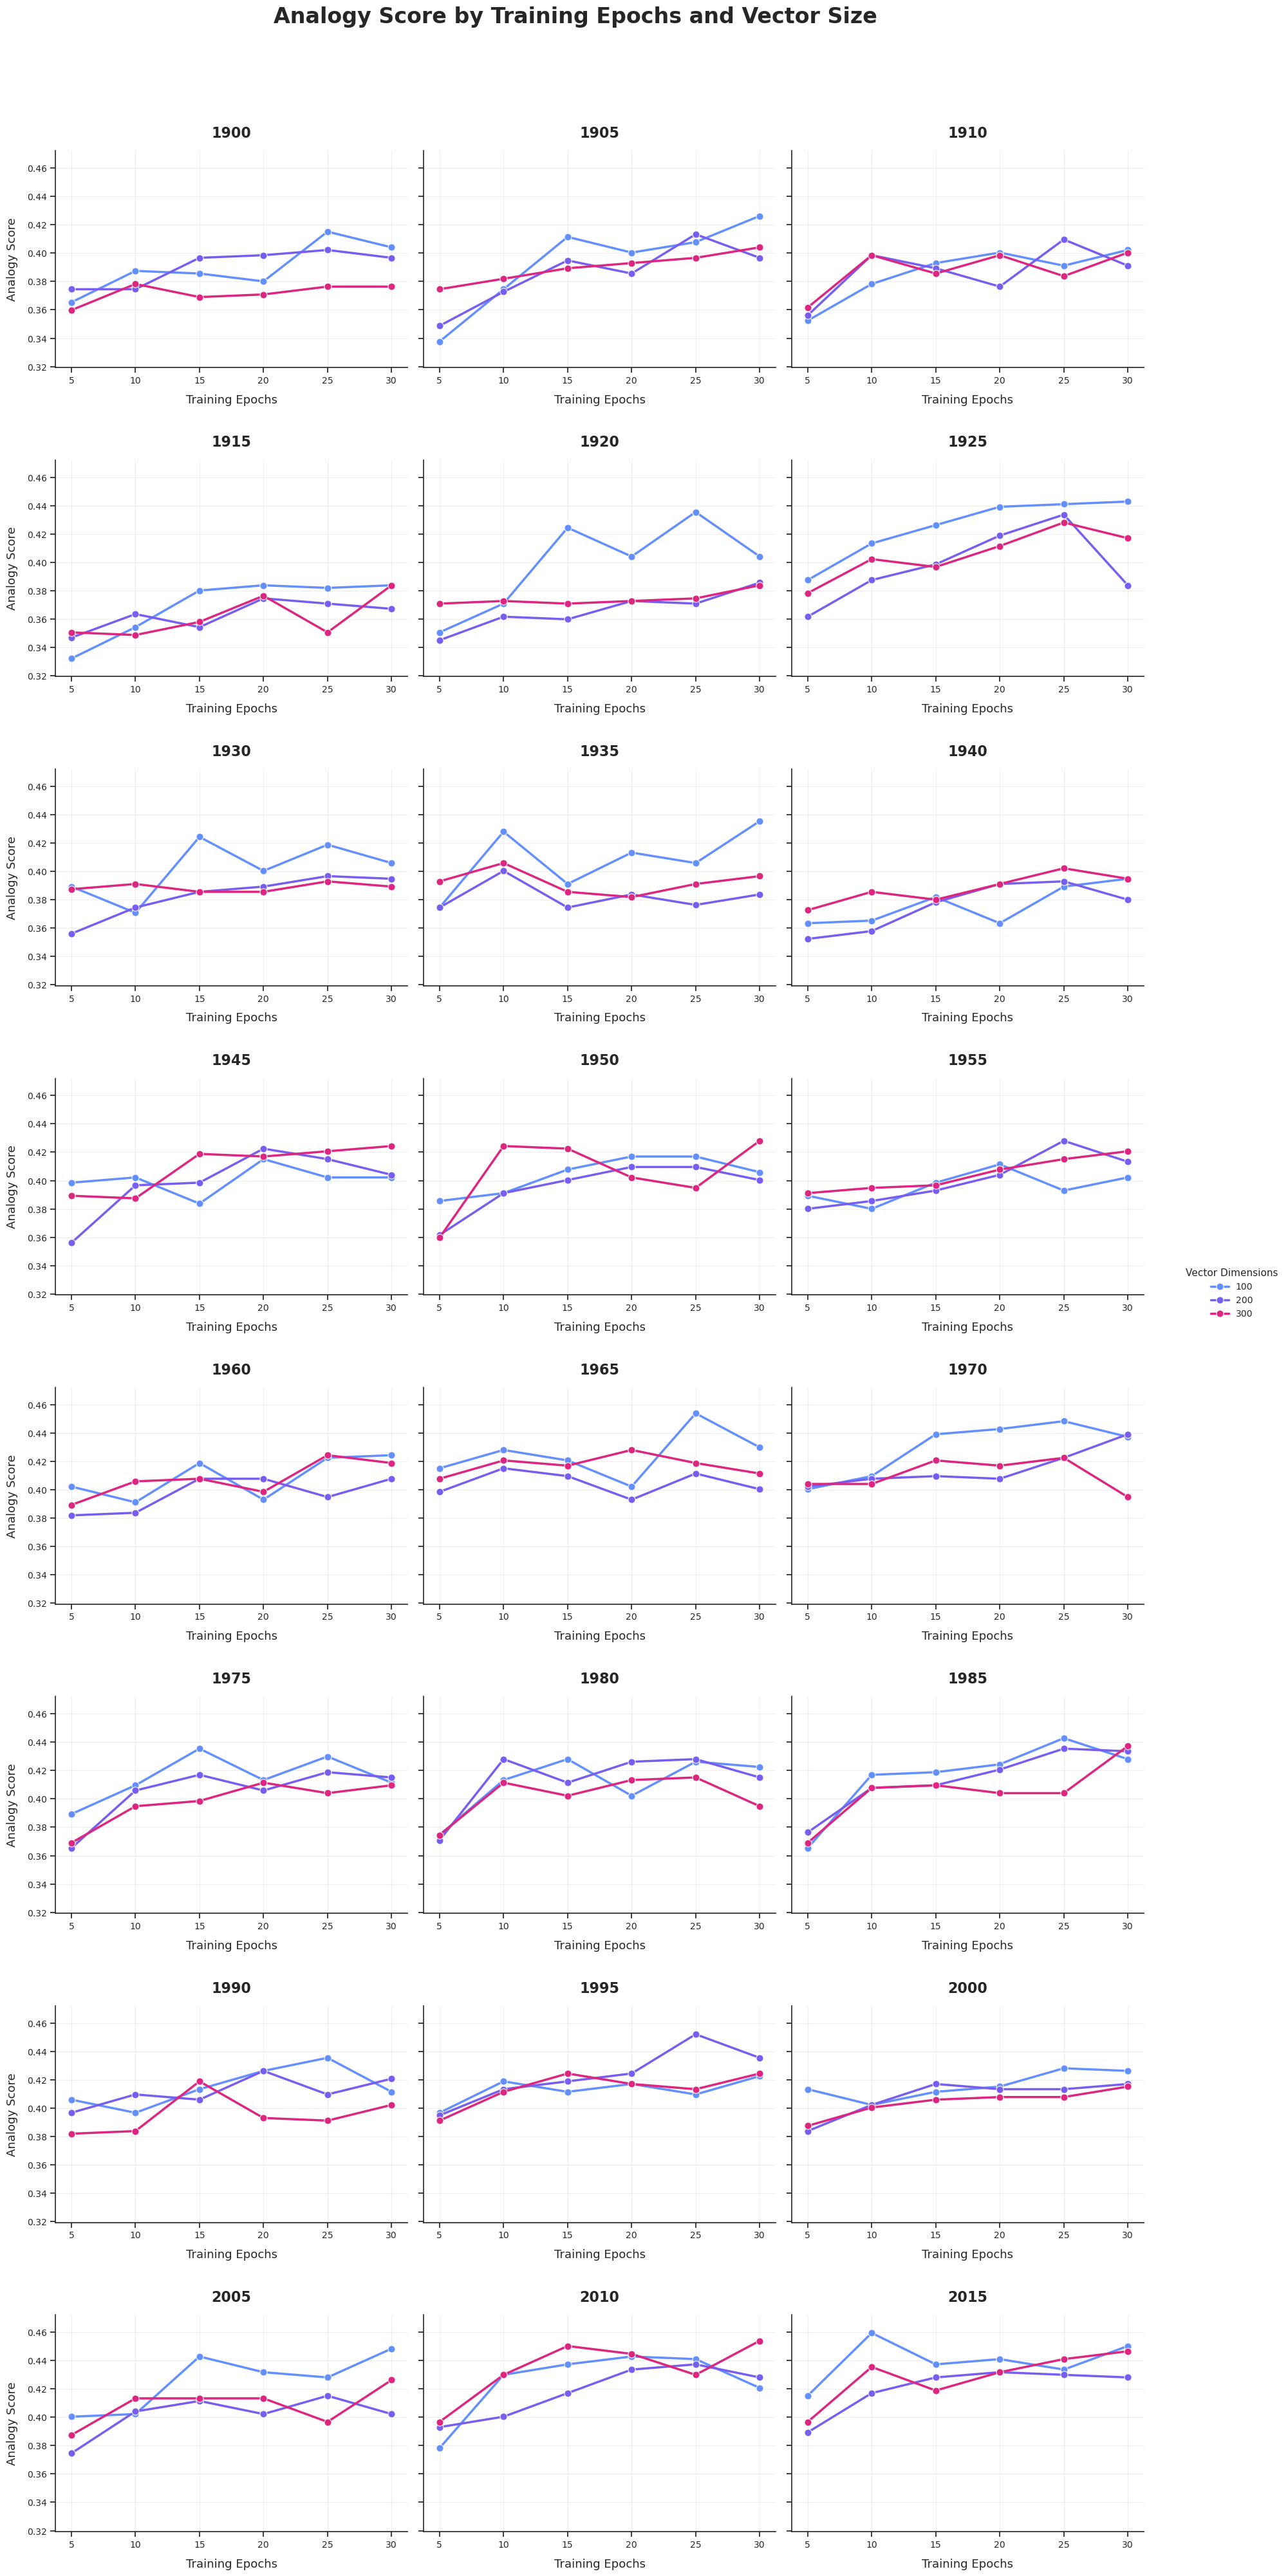

In [4]:
eval_file = '/scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

plot_evaluation_results(
    csv_file=eval_file,
    verbose=False,
    metric='analogy_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Analogy Score by Training Epochs and Vector Size'
)

### Regression Analysis
The code below runs a regression analysis on the similarity and analogy results.
#### Predictors of Similarity Performance
The model coefficient and dot-and-whisker plots show that — not surprisingly — similarity performance is best for recent corpora. The number of training epochs don't seem to matter; in fact, the year-by-epochs interaction appears to reflect the fact that more epochs are detrimental to model quality for the earliest corpora. The small positive effects of vector dimensions and the year-by-dimensions interaction indicate that adding features improves model quality a bit, especially for the most recent corpora.

Loading data...
Loaded 432 observations
Number of years: 24

Model specification:
  Formula: similarity_score ~ scale(year) + scale(vector_size) + scale(epochs) + C(approach) + scale(year):scale(vector_size) + scale(year):scale(epochs) + scale(vector_size):scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Model converged successfully!

                   Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     similarity_score
No. Observations:      432         Method:                 REML            
No. Groups:            24          Scale:                  0.0001          
Min. group size:       18          Log-Likelihood:         1341.0177       
Max. group size:       18          Converged:              Yes             
Mean group size:       18.0                                                
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z  

/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


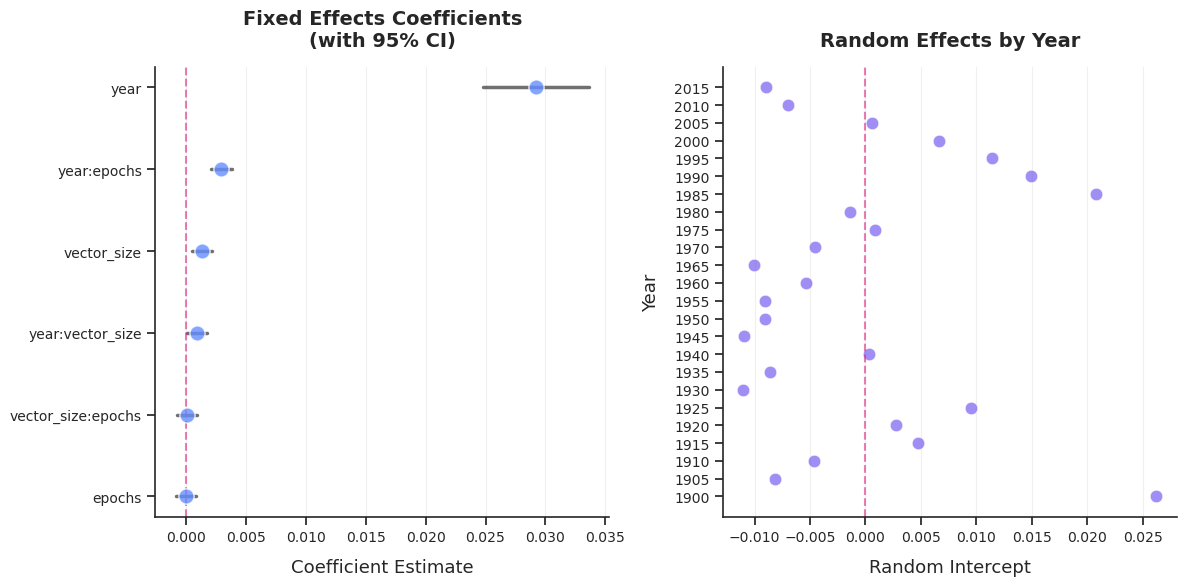

In [8]:
eval_file = '/scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

results = run_regression_analysis(
    csv_file=eval_file,
    model_type="auto",
    outcome='similarity_score',
    predictors=['year', 'vector_size', 'epochs', 'approach'],
    interactions=[('year', 'vector_size'), ('year', 'epochs'), ('vector_size', 'epochs')],
)

plot_regression_results(results)

#### Predictors of Analogy Performance
The regression results for analogy performance confirm what we saw in the plots. More recent corpora perform better, and more training epochs contribute to better performance. Although it wasn't immediately apparent in the plots, adding vector dimensions negatively impacts analogy performance — an effect not moderated by year.

Loading data...
Loaded 432 observations
Number of years: 24

Model specification:
  Formula: analogy_score ~ scale(year) + scale(vector_size) + scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Mixed-effects model failed (Singular matrix). Falling back to OLS regression...
Model converged successfully!

                            OLS Regression Results                            
Dep. Variable:          analogy_score   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     155.2
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           4.53e-68
Time:                        21:28:34   Log-Likelihood:                 1174.9
No. Observations:                 432   AIC:                            -2342.
Df Residuals:                     428   BIC:                            -2325.
Df Model:                           3       

/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


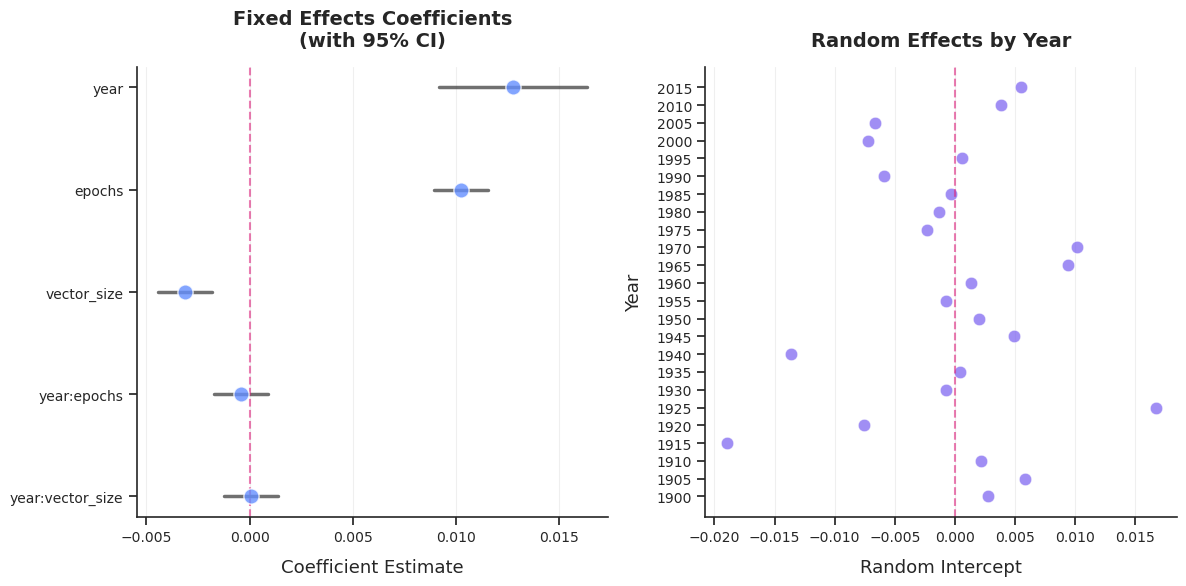

In [7]:
eval_file = '/scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

results = run_regression_analysis(
    csv_file=eval_file,
    model_type="auto",
    outcome='analogy_score',
    predictors=['year', 'vector_size', 'epochs', 'approach'],
    interactions=[('year', 'vector_size'), ('year', 'epochs')],
)

plot_regression_results(results)

## **Train Final Models**

In [ ]:
src_path = '/scratch/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files'

setup_notebook_logging(
    workflow_name="training_workflow",
    console=False
)

train_models(
    corpus_path=src_path,
    dir_suffix='final',
    years=(1900, 2015),
    year_step=1,
    weight_by=('none',),
    vector_size=(200,),
    window=(4,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(10,),
    max_parallel_models=33,
    workers_per_model=3,
    mode="resume",
    unk_mode="strip",
    use_corpus_file=True
)


Scanning for existing models...
  Valid models found:    0
  Invalid/partial:       0

WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-10 22:11:06

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             .../edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/5grams_pivoted.db
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_final
Log directory:        ...edk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_final/training
Parallel models:      33

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2015 (116 years)
Weighting:            ('none',)
Vector size:          (200,)
Context window:       (4,)
Minimum word count:   (1,)
Approach:             ('skip-gr